In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pandas==0.25.3
!pip install pandas_profiling

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Importing all modules required

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import json
import re
import operator
%matplotlib inline
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
import plotly.offline as py
import plotly.express as px
from tqdm import *
import warnings
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Methods Initialization

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
warnings.filterwarnings("ignore")
pca = PCA(n_components=2)

Read Data and view the data shape and columns

In [4]:
NYJobData=pd.read_csv('/content/drive/My Drive/ColabDataInputs/data.csv')
print("The details of the dataset provided are \n")
print(NYJobData.info())
print('\n The columns of the data set are \n')
print(NYJobData.columns)

The details of the dataset provided are 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 28 columns):
Job ID                           3228 non-null int64
Agency                           3228 non-null object
Posting Type                     3228 non-null object
# Of Positions                   3228 non-null int64
Business Title                   3228 non-null object
Civil Service Title              3228 non-null object
Title Code No                    3228 non-null object
Level                            3228 non-null object
Job Category                     3226 non-null object
Full-Time/Part-Time indicator    2941 non-null object
Salary Range From                3228 non-null float64
Salary Range To                  3228 non-null float64
Salary Frequency                 3228 non-null object
Work Location                    3228 non-null object
Division/Work Unit               3228 non-null object
Job Description                  3228 non

Initialize and create functions to be used in this code

In [34]:
def valuewithpercent(subset,overall):
  test = round(int(subset)*100/int(overall),2)
  OutStr = str(subset)+' ('+str(test)+'%)'
  return OutStr

def ProcesTxt(txtinput):
  txtinput = str(txtinput)
  lowertxt = txtinput.lower()
  SentSplit = lowertxt.split(sep = '\t')
  FinalTxt = []
  for i in SentSplit:
    lowertxtWOSpl = re.sub('[^A-Za-z0-9 ]+', '', i)
    word_tokens = word_tokenize(lowertxtWOSpl)
    LemmaTxt = [lemmatizer.lemmatize(w) for w in word_tokens if not w in stop_words]
    CleanTxt = " ".join(LemmaTxt)
    if len(CleanTxt) > 0:
      FinalTxt.append(CleanTxt)
  return FinalTxt

def bar_plot(xval,yval,xlabel,ylabel,title,textlabel):
  plt.figure(figsize = (15,10))
  ax = sns.barplot(x = xval,y = yval)
  plt.xticks(rotation = 60)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  FileName = re.sub('[^A-Za-z0-9 ]+', '', title)
  for i in range(len(textlabel)):
    ax.text(x = i,  y = yval[i]/2,s = textlabel[i], size = 10,rotation = 90)
  plt.savefig('/content/drive/My Drive/ColabOutputs/'+FileName+'_BarPlt.png')
  plt.show()

def pieplot(labels,sizes):
  explode = [0.07 for i in labels]
  explode = tuple(explode)
  # Plot
  plt.figure(figsize = (3,3))
  plt.pie(sizes, labels=labels,explode = explode, autopct='%1.1f%%', shadow=True, startangle=90)
  plt.axis('equal')
  FileName = re.sub('[^A-Za-z0-9 ]+', '', title)
  plt.savefig('/content/drive/My Drive/ColabOutputs/'+FileName+'_pieplot.png')
  plt.show()

def hbarplot(xval,yval,xlabel,ylabel,title,datalabel):
  y_pos = np.arange(len(xval))
  plt.figure(figsize=(10,8))
  plt.barh(y_pos, yval, align='center', alpha=0.5)
  plt.yticks(y_pos, xval,size = 10)
  plt.xlabel(ylabel)
  plt.ylabel(xlabel)
  plt.title(title)
  FileName = re.sub('[^A-Za-z0-9 ]+', '', title)
  for i in range(len(datalabel)):
    plt.text(y = i,  x = yval[i]/2,s = datalabel[i], size = 8)
  plt.savefig('/content/drive/My Drive/ColabOutputs/'+FileName+'_HBarplt.png')
  plt.show()

def genWordCloud(Attribute,dataframe):
  tempDF = dataframe[[Attribute]]
  tempDF['CleanedAttr'] = tempDF[Attribute].apply(lambda x: ProcesTxt(x))
  ItemsList = [item for sublist in tempDF['CleanedAttr'].to_list() for item in sublist]
  CounterItems = Counter(ItemsList)
  tempDF2 = pd.DataFrame(list(CounterItems.items()),columns = ['ListName','Count'])
  text = " ".join(review for review in tempDF2.ListName)
  FileName = re.sub('[^A-Za-z0-9 ]+', '', Attribute)
  wordcloud = WordCloud( background_color="white").generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.savefig('/content/drive/My Drive/ColabOutputs/'+FileName+'_WordCloud.png')
  plt.show()
  return tempDF,tempDF2

def SalNormalize(Frequency,Salary):
  if Frequency == 'Annual':
    #Assuming 160 hours working in a month & 12 months annually
    ActSal = Salary/12/160
  elif Frequency == 'Hourly':
    #Normalizing to hourly rate
    ActSal = Salary
  elif Frequency == 'Daily':
    #Assuming 8 hours working in a day
    ActSal = Salary / 8
  return round(ActSal,2)

def getCleanWordList(Attrib,DF):
  CleanWordList = []
  for description in tqdm(DF[Attrib]):
    description=str(description)
    description = description.lower()
    description = re.sub('[^a-zA-z\s]', '', description)
    description = re.sub('\s+', ' ', description) 
    tokens = nltk.word_tokenize(description)
    description = [i for i in tokens if not i in stop_words]
    lemma = WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    description =" ".join(description)
    CleanWordList.append(description)
  return CleanWordList

def getJobCategories(x):
  l = x.replace('&', ',').split(',')
  l = [x.strip().rstrip(',') for x in l]
  return l

def lineplot(startrange,endrange,pltvals,xlbl,ylbl,title):
  plt.style.use("fivethirtyeight")
  plt.plot(range(startrange, endrange), pltvals)
  for x,y in zip(range(startrange, endrange),pltvals):
    label = "{:.2f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', size=8)
  plt.xticks(range(startrange, endrange))
  plt.xlabel(xlbl)
  plt.ylabel(ylbl)
  plt.title(title)
  FileName = re.sub('[^A-Za-z0-9 ]+', '', title)
  plt.savefig('/content/drive/My Drive/ColabOutputs/'+FileName+'_LinePlt.png')
  plt.show()

def getTopwordslist(ngrams,features,attribName,DF,topCount):
  vectorizer = CountVectorizer(ngram_range = (ngrams,ngrams),max_features=features,stop_words="english") 
  descriptionMatrix = vectorizer.fit_transform(getCleanWordList(attribName,DF)).toarray()
  dictionary = vectorizer.vocabulary_.items()
  word = []
  count = []
  for key, value in dictionary:
    word.append(key)
    count.append(value)
  wordser = pd.Series(count, index=word)
  wordser = wordser.sort_values(ascending=False)
  top_words = wordser.head(topCount)
  hbarplot(top_words.index,top_words.values,'TopSkill Name','Count','Top US Skills vs Salary',top_words.values)
  return top_words

def getPCAattr(dfx,dfy):
  x = dfx.values
  PrinComp = pca.fit_transform(x)
  Yvar = list(dfy.columns)
  PrincDF = pd.DataFrame(data = PrinComp , columns = ['pcol1','pcol2'])
  PCADF = pd.concat([PrincDF, dfy], axis = 1)
  fig = plt.figure(figsize = (12,12))
  pcp = fig.add_subplot(1,1,1) 
  pcp.set_xlabel('Principal Component 1', fontsize = 15)
  pcp.set_ylabel('Principal Component 2', fontsize = 15)
  plt.grid( linestyle='-', linewidth=1)
  pcp.set_title('2 component PCA', fontsize = 20)
  loanstat =  list(np.unique(dfy.values))
  colors = ['g', 'r']
  for target, color in zip(loanstat,colors):
      indicesToKeep = PCADF[Yvar[0]] == target
      pcp.scatter(PCADF.loc[indicesToKeep, 'pcol1'], PCADF.loc[indicesToKeep, 'pcol2'], c = color, s = 50)
      pcp.legend(loanstat)
      pcp.grid()
  return PCADF

Read Data Dictionary and understand the attributes

In [9]:
NYDataDict = pd.read_excel('/content/drive/My Drive/ColabDataInputs/Data Dictionry.xlsx')
NYDataDict.rename(columns={"Column Description (including the unit of measure, acronyms and range of possible values)": "Column Description"}, inplace = True)
for ind in NYDataDict.index:
  print(ind+1, ') ',NYDataDict['Column Name'][ind],' - ', NYDataDict['Column Description'][ind],'\n') 


1 )  Job ID  -  The job opening identification (“Job ID”) number that corresponds to and represents a job posting notice published on behalf of a New York City agency.  

2 )  Agency  -  Name of the New York City agency (“agency” or “hiring agency”) where a job vacancy exists. 

3 )  Posting Type  -  Identifies whether a job posting is an Internal or External posting. Internal postings are available to City employees only and external postings are available to the general public. 

4 )  # Of Positions  -  The total number of vacancies to be filled under the job ID listed. 

5 )  Business Title  -  The "business title", or "office title", for the job posting listed. 

6 )  Civil Service Title  -  The civil service title for the job posting listed. 

7 )  Title Code No.  -  The Title Code Number (“Title Code No.”) that corresponds to the civil service title posted.  

8 )  Level   -  The civil service title assignment level that the posted position is being filled at. Civil service title

*   Missing values analysis and understand the % of missing values in each attribute of the dataset. 
*   Bar Plot for all attributes and attribues only with missing values
*   Assign Unknown for Missing values in 'Full-Time/Part-Time indicator' attribute
*   Pandas profiling to understand more on each attributes of the dataset

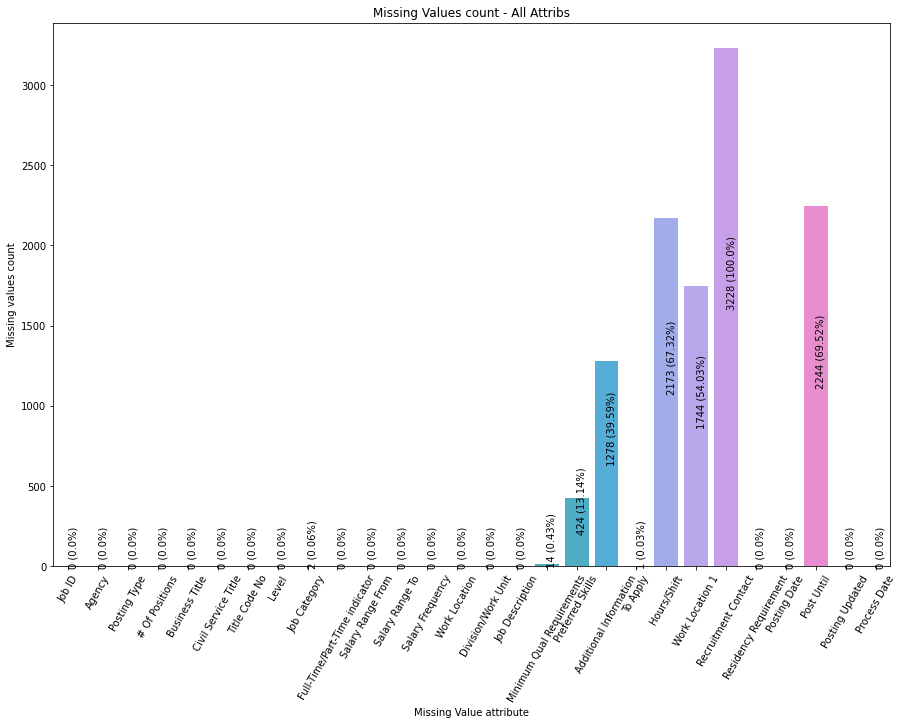

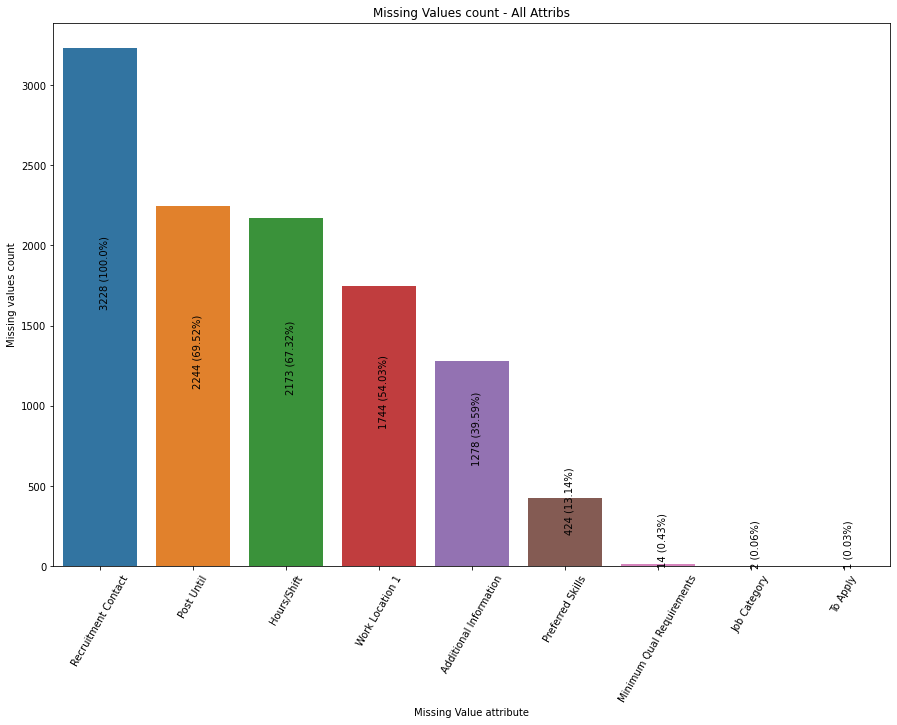

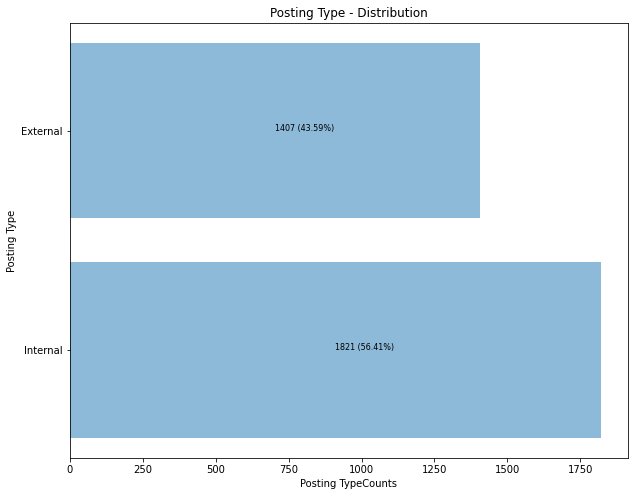

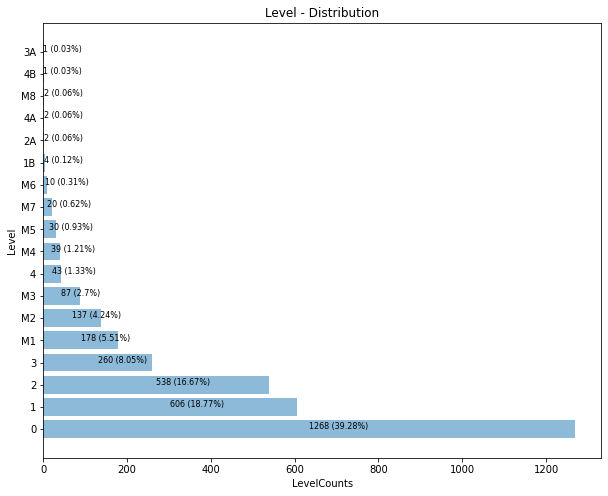

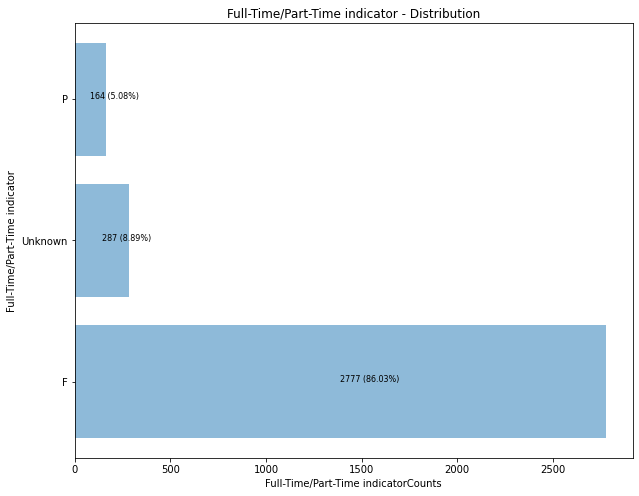

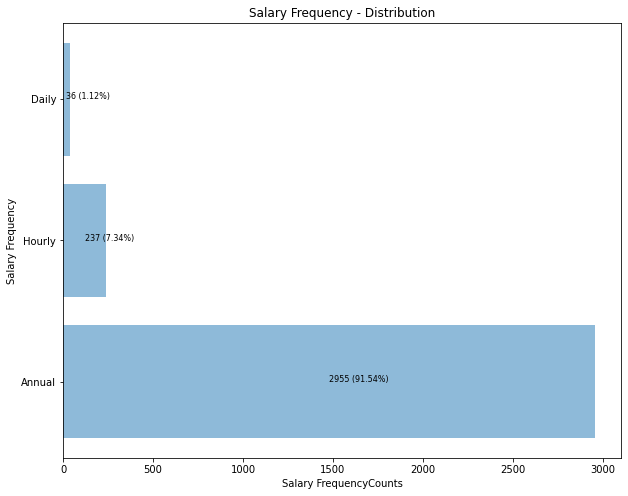

In [12]:
NYJobDataNullVals = NYJobData.isnull().sum().to_frame().reset_index()
NYJobDataNullVals.columns
NYJobDataNullVals.rename(columns={"index":"AttributeName",0:"MissingCount"},inplace = True)
NYJobDataNullVals['MissingPercent'] = NYJobDataNullVals['MissingCount'].apply(lambda x: valuewithpercent(x,3228))
NYJobOnlyNull = NYJobDataNullVals[NYJobDataNullVals.MissingCount != 0 ]
NYJobOnlyNull.sort_values(by = ['MissingCount'], ascending = False, inplace= True)

bar_plot(list(NYJobDataNullVals['AttributeName']),list(NYJobDataNullVals['MissingCount']),"Missing Value attribute","Missing values count","Missing Values count - All Attribs",list(NYJobDataNullVals['MissingPercent']))
bar_plot(list(NYJobOnlyNull['AttributeName']),list(NYJobOnlyNull['MissingCount']),"Missing Value attribute","Missing values count","Missing Values count - All Attribs",list(NYJobOnlyNull['MissingPercent']))

NYJobData['Full-Time/Part-Time indicator'].fillna("Unknown", inplace=True)
for j in ['Posting Type','Level','Full-Time/Part-Time indicator','Salary Frequency']:
  hbarplot(NYJobData[j].value_counts().index.to_list(),NYJobData[j].value_counts().to_list(),j,j+ 'Counts',j +' - Distribution',[valuewithpercent(i,sum(NYJobData[j].value_counts().to_list())) for i in NYJobData[j].value_counts().to_list()])

prof = ProfileReport(NYJobData)
prof.to_file('/content/drive/My Drive/ColabOutputs/NYJobData.html')

In [13]:
NYJobData.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Code No', 'Level', 'Job Category',
       'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To',
       'Salary Frequency', 'Work Location', 'Division/Work Unit',
       'Job Description', 'Minimum Qual Requirements', 'Preferred Skills',
       'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1',
       'Recruitment Contact', 'Residency Requirement', 'Posting Date',
       'Post Until', 'Posting Updated', 'Process Date'],
      dtype='object')

Generate wordcloud for textual attributes

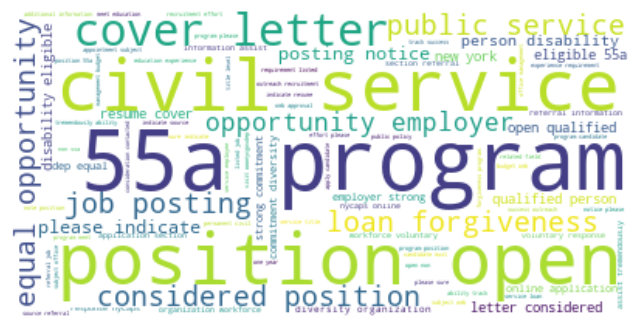

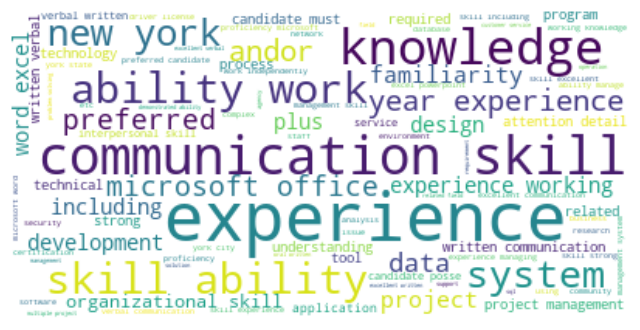

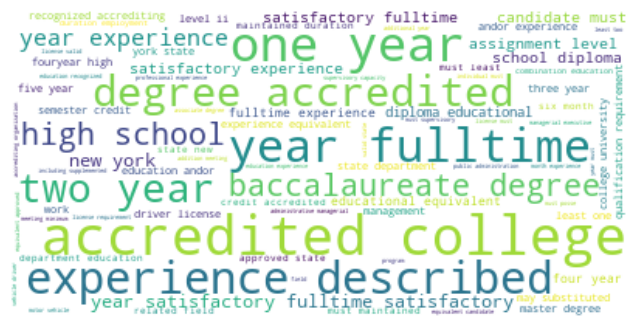

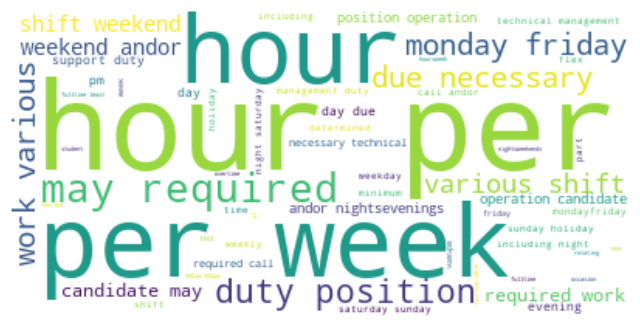

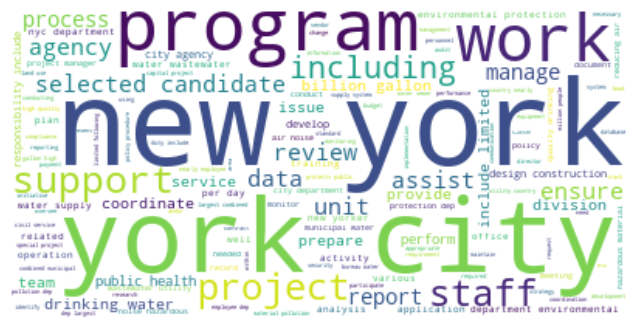

In [14]:
for i in ['Additional Information','Preferred Skills','Minimum Qual Requirements','Hours/Shift','Job Description']:
  genWordCloud(i,NYJobData)

*   Normalize the Salary Range from & Salary range To attributes as they are in either Hourly, Daily or Annually. Normalizing all the values to Hourly
*   Removing Recruitment Contact, Process Date as they are constant. Removing old Salary Range from, To & Salary Frequency. Removing Post until, Hours, Work Location as they have more than 40% missing values

In [15]:
NYJobData['NormalizedToSalHrly'] = NYJobData.apply(lambda x: SalNormalize(x['Salary Frequency'],x['Salary Range To']), axis = 1)
NYJobData['NormalizedFromSalHrly'] = NYJobData.apply(lambda x: SalNormalize(x['Salary Frequency'],x['Salary Range From']), axis = 1)
#Removing Recruitment Contact, Process Date as they are constant.
#Removing old Salary Range from, To & Salary Frequency
#Removing Post until, Hours, Work Location as they have more than 40% missing values
NYJobData1 = NYJobData.drop(columns = ['Recruitment Contact','Process Date','Salary Range From', 'Salary Range To','Post Until','Hours/Shift','Work Location 1','Additional Information'],axis = 1)

Binning the Normalized Salary Range to attribute to 4 bins ('Silver', 'Gold', 'Platinum', 'Diamond') by creating a new feature  SalaryRangeBin

In [16]:
bin_labels = ['Silver', 'Gold', 'Platinum', 'Diamond']
NYJobData1['SalaryRangeBin'] = pd.qcut(NYJobData1['NormalizedToSalHrly'], q=4, labels=bin_labels)

SkillSets is a textual column. Performing NLP techniques using function getCleanWordList. Vectorizing the clean text and using Bigrams. Plotting bar graph for top 50 bigrams based on count

100%|██████████| 3228/3228 [00:02<00:00, 1597.80it/s]


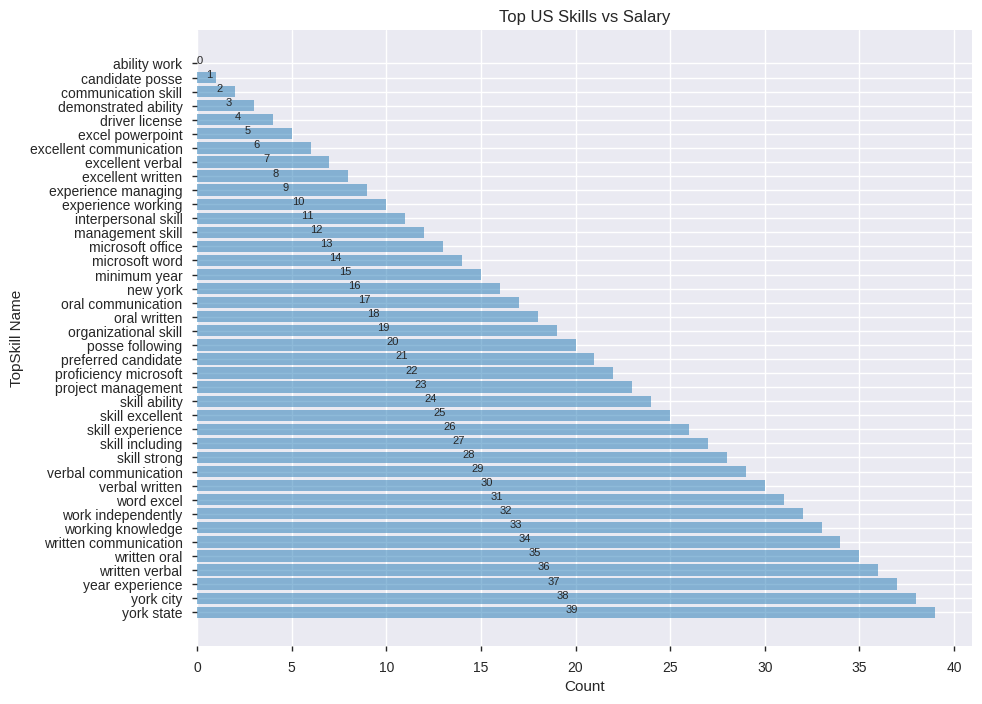

york state                 39
york city                  38
year experience            37
written verbal             36
written oral               35
written communication      34
working knowledge          33
work independently         32
word excel                 31
verbal written             30
verbal communication       29
skill strong               28
skill including            27
skill experience           26
skill excellent            25
skill ability              24
project management         23
proficiency microsoft      22
preferred candidate        21
posse following            20
organizational skill       19
oral written               18
oral communication         17
new york                   16
minimum year               15
microsoft word             14
microsoft office           13
management skill           12
interpersonal skill        11
experience working         10
experience managing         9
excellent written           8
excellent verbal            7
excellent 

In [35]:
NYJobData1['skillsList']=NYJobData1['Preferred Skills'].copy()
NYJobData1['skillsList']=getCleanWordList('skillsList',NYJobData1)
getTopwordslist(2,40,'skillsList',NYJobData1,50)

Experience is within the textual field 'Minimum Qual Requirements'. Using regex to extract the experience

In [23]:
NYJobData1['minimumRequirement']=NYJobData1['Minimum Qual Requirements'].copy()
NYJobData1['minimumRequirement']=getCleanWordList('minimumRequirement',NYJobData1)
### regex to extract experience from Minimum requirements
NYJobData1['yearExperience']=NYJobData1['minimumRequirement'].str.extract(r'(\w+)\syear.+experience')
print(NYJobData1['yearExperience'].unique())
print(NYJobData1['yearExperience'].value_counts())
for i in ['onehalf','equivalent','college','minimum','science', 'nurse']:
  print('The items with text ', i)
  print(NYJobData1[NYJobData1['yearExperience']==i]['minimumRequirement'],"\n")

100%|██████████| 3228/3228 [00:04<00:00, 806.56it/s]


['two' 'five' 'three' 'onehalf' 'one' 'four' nan 'six' 'ten' 'equivalent'
 'eight' 'college' 'seven' 'minimum' 'science' 'nurse']
one           761
two           661
four          542
three         324
five          302
six           184
onehalf        24
eight          14
seven          10
ten             7
science         4
equivalent      4
college         2
nurse           2
minimum         2
Name: yearExperience, dtype: int64
The items with text  onehalf
6       baccalaureate degree accredited college six mo...
294     baccalaureate degree accredited college six mo...
329     baccalaureate degree accredited college six mo...
378     baccalaureate degree accredited college six mo...
462     baccalaureate degree accredited college six mo...
505     baccalaureate degree accredited college six mo...
506     baccalaureate degree accredited college six mo...
560     baccalaureate degree accredited college six mo...
561     baccalaureate degree accredited college six mo...
577     baccal

In [24]:
NYJobData1[NYJobData1['yearExperience']=='onehalf']['minimumRequirement'][6]

'baccalaureate degree accredited college six month satisfactory fulltime professional experience procurement good service construction constructionrelated service professional technical administrative experience contract negotiationmanagement associate degree completion semester credit accredited college month satisfactory fulltime professional experience described fouryear high school diploma educational equivalent two onehalf year satisfactory full time professional experience described combination education andor experience equivalent college education may substituted professional experience rate semester credit accredited college month experience however candidate must least four year high school diploma educational equivalent month experience described special note eligible placement assignment level ii individual must meeting minimum requirement either one year served assignment level one additional year experience described eligible placement assignment level iii individual must

*   Based on reading the text one by one the team is looking for 1 year experience in the text containing [equivalent','college','minimum','science', 'nurse']. So adding them as 1 year experience.
*   For OneHalf experience, they are looking for 2 on halfyear experience so mapping that to 2

Mapping all numbers to texts

In [25]:
print(NYJobData1['yearExperience'].value_counts().index)
YearMap = {'one':1, 'two':2, 'four':4, 'three':3, 'five':5, 'six':6, 'onehalf':2, 'eight':8, 'seven':7, 'ten':10, 'science':1, 'equivalent':1, 'college':1, 'minimum':1, 'nurse':1}
NYJobData1['YrsExpVal'] = NYJobData1['yearExperience'].map(YearMap)
NYJobData1['YrsExpVal'].value_counts()

Index(['one', 'two', 'four', 'three', 'five', 'six', 'onehalf', 'eight',
       'seven', 'ten', 'science', 'equivalent', 'college', 'nurse', 'minimum'],
      dtype='object')


1.0     775
2.0     685
4.0     542
3.0     324
5.0     302
6.0     184
8.0      14
7.0      10
10.0      7
Name: YrsExpVal, dtype: int64

*   Job Category is a textual field with multiple categories for a job
*   Applying RegEx to clean the text and split the Job categories and getting the Top 25 categories based on count
*   Bar Plot of the top 25 categories extracted

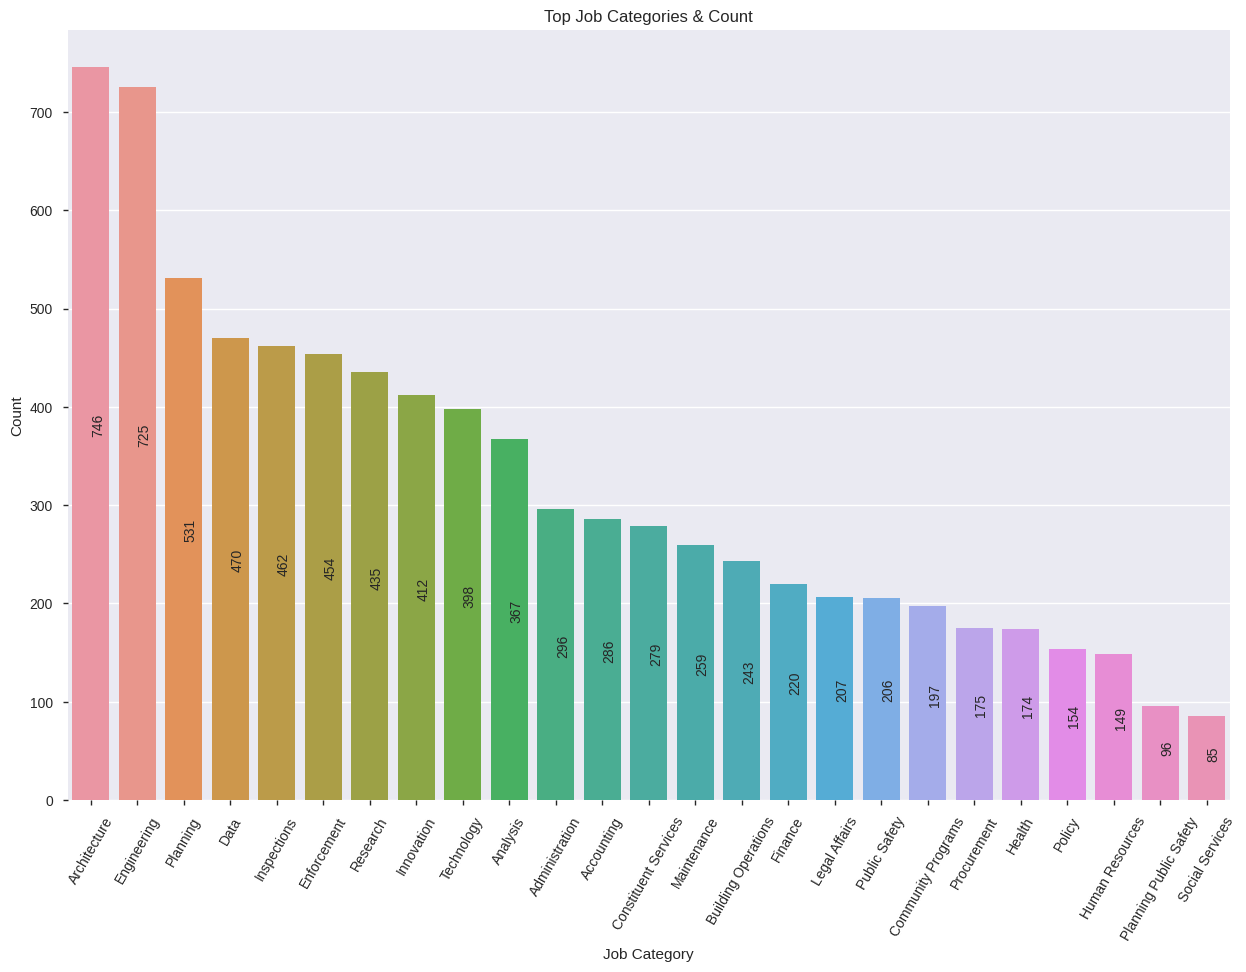

In [27]:
NYJobData1['Job Category'].dropna().apply(getJobCategories)
JobCats = NYJobData1['Job Category'].dropna().apply(getJobCategories).to_list()
JobCats1 = [item for sublist in JobCats for item in sublist]
JobCatsDF = pd.DataFrame(JobCats1, columns = ['JobCategory'])
JobCatsDF = JobCatsDF[JobCatsDF['JobCategory'] != '']
PopularCateg = JobCatsDF['JobCategory'].value_counts().iloc[:25]
#BarPlot of the Job Categories
bar_plot(PopularCateg.index,PopularCateg.values,'Job Category','Count','Top Job Categories & Count',PopularCateg.values)

Distribution plot of Years of Experience required which was extracted in previous steps from 'Minimum Qual Requirements' attribute

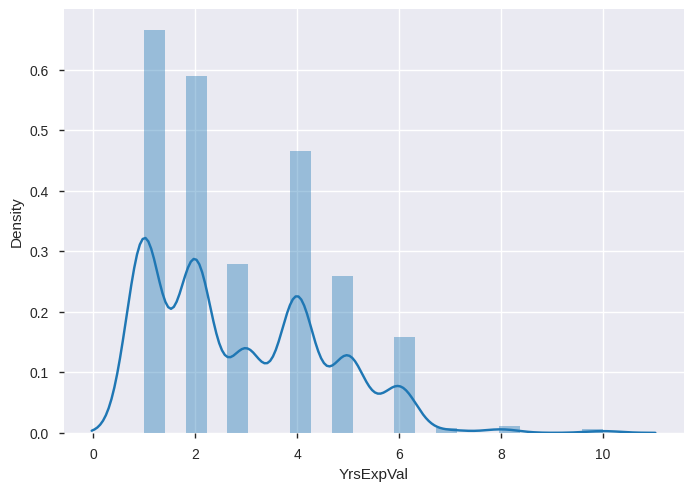

In [28]:
sns.distplot(NYJobData1['YrsExpVal'].dropna())

Joint plot to understand the relationship between Salary & Years of Experience

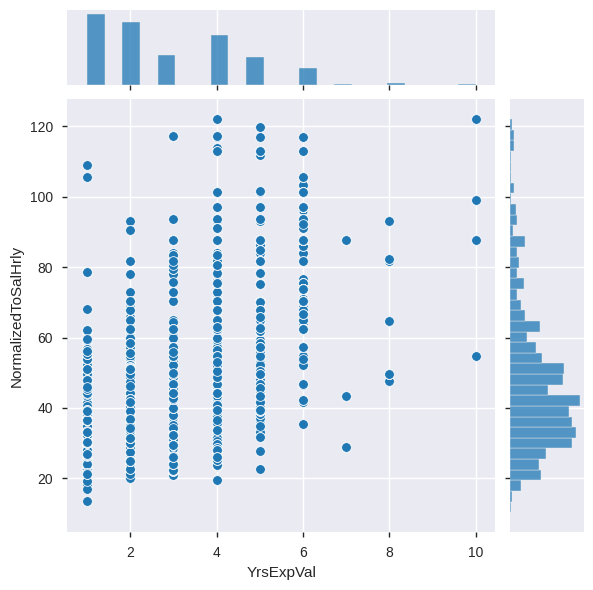

In [29]:
sns.jointplot(x='YrsExpVal', y='NormalizedToSalHrly', data=NYJobData1[['YrsExpVal','NormalizedToSalHrly']])

In [30]:
NYJobData1.columns

Index(['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title',
       'Civil Service Title', 'Title Code No', 'Level', 'Job Category',
       'Full-Time/Part-Time indicator', 'Salary Frequency', 'Work Location',
       'Division/Work Unit', 'Job Description', 'Minimum Qual Requirements',
       'Preferred Skills', 'To Apply', 'Residency Requirement', 'Posting Date',
       'Posting Updated', 'NormalizedToSalHrly', 'NormalizedFromSalHrly',
       'SalaryRangeBin', 'skillsList', 'minimumRequirement', 'yearExperience',
       'YrsExpVal'],
      dtype='object')

Understanding relationship between Skills & Max Salaries/Hr.

In [31]:
skillvsSalaries = NYJobData1[['skillsList', 'NormalizedFromSalHrly', 'NormalizedToSalHrly','Job Category']]
skillvsSalaries.columns=['skillsList','minSalary','maxSalary','jobCategory']

TopSalWSkills=pd.DataFrame(skillvsSalaries.groupby(['skillsList'])['maxSalary'].mean().nlargest(15)).reset_index()
print('Max Salary is in USD/Hour')
print(TopSalWSkills)

Max Salary is in USD/Hour
                                           skillsList  maxSalary
0   excellent analytical legal writing negotiation...     122.08
1   executive deputy commissioner excellent manage...     119.79
2   minimum five year experience public health inc...     117.30
3   minimum seven year experience public health in...     117.30
4   qualification least five year experience manag...     117.30
5   ten year businessindustry experience public pe...     117.30
6   valid holder cciso certified chief information...     117.30
7   key competency leadership capacity building pr...     117.06
8   master degree accounting related field five ye...     117.06
9   minimum ten year fulltime satisfactory profess...     117.06
10  deputy commissioner position requires excellen...     113.85
11  bachelor degree accounting computer science ce...     113.15
12  education experience preferred master degree a...     113.15
13  least seven year experience managing legislati...     113.15

Vectorized the text in teh Skillset and creatd trigrams and fetch the top 15 skills sets which are highly paid in the US Market. Plotted a horizontal Bar Plot

100%|██████████| 15/15 [00:00<00:00, 701.57it/s]


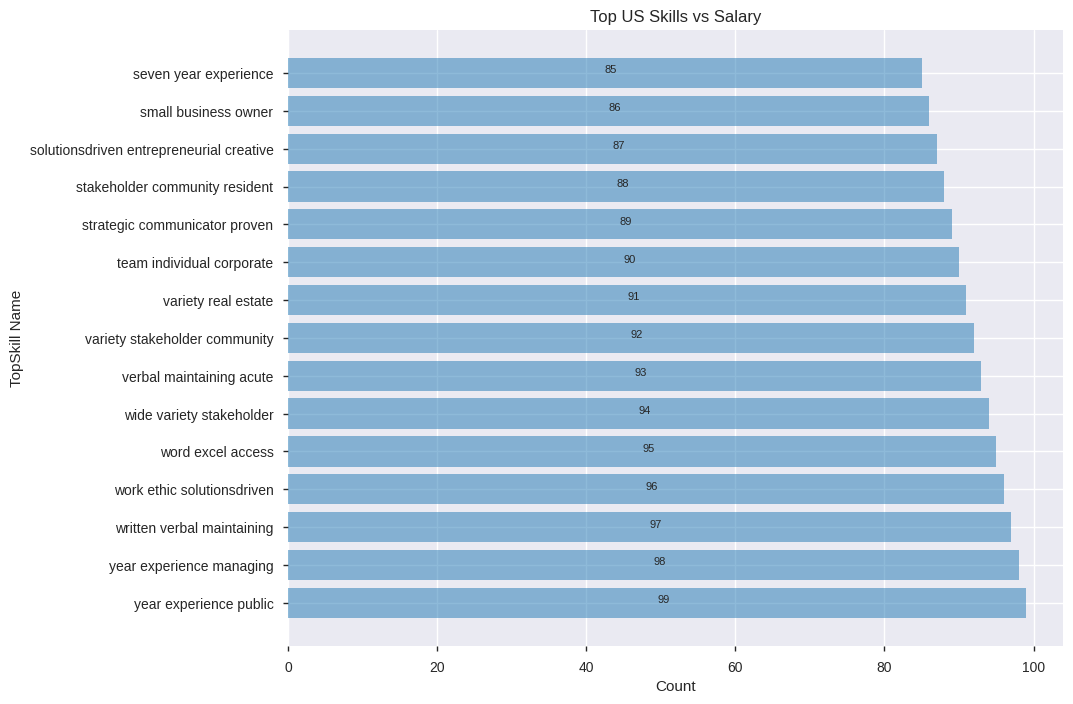

year experience public                      99
year experience managing                    98
written verbal maintaining                  97
work ethic solutionsdriven                  96
word excel access                           95
wide variety stakeholder                    94
verbal maintaining acute                    93
variety stakeholder community               92
variety real estate                         91
team individual corporate                   90
strategic communicator proven               89
stakeholder community resident              88
solutionsdriven entrepreneurial creative    87
small business owner                        86
seven year experience                       85
dtype: int64

In [36]:
getTopwordslist(3,100,'skillsList',TopSalWSkills,15)

Getting the details of the skills sets for the highly paid Job categories

The Top 10 Job Categories
                                        jobCategories  count
0                 Engineering Architecture & Planning    524
1                        Technology Data & Innovation    362
2                   Building Operations & Maintenance    220
3                                       Legal Affairs    207
4             Public Safety Inspections & Enforcement    204
5           Constituent Services & Community Programs    188
6                                              Health    174
7                    Administration & Human Resources    149
8                    Finance Accounting & Procurement    143
9                          Policy Research & Analysis    124
10  Engineering Architecture & Planning Public Saf...     96
11                                    Social Services     85
12  Finance Accounting & Procurement Policy Resear...     49
13         Communications & Intergovernmental Affairs     35
14  Engineering Architecture & Planning Technology...     3

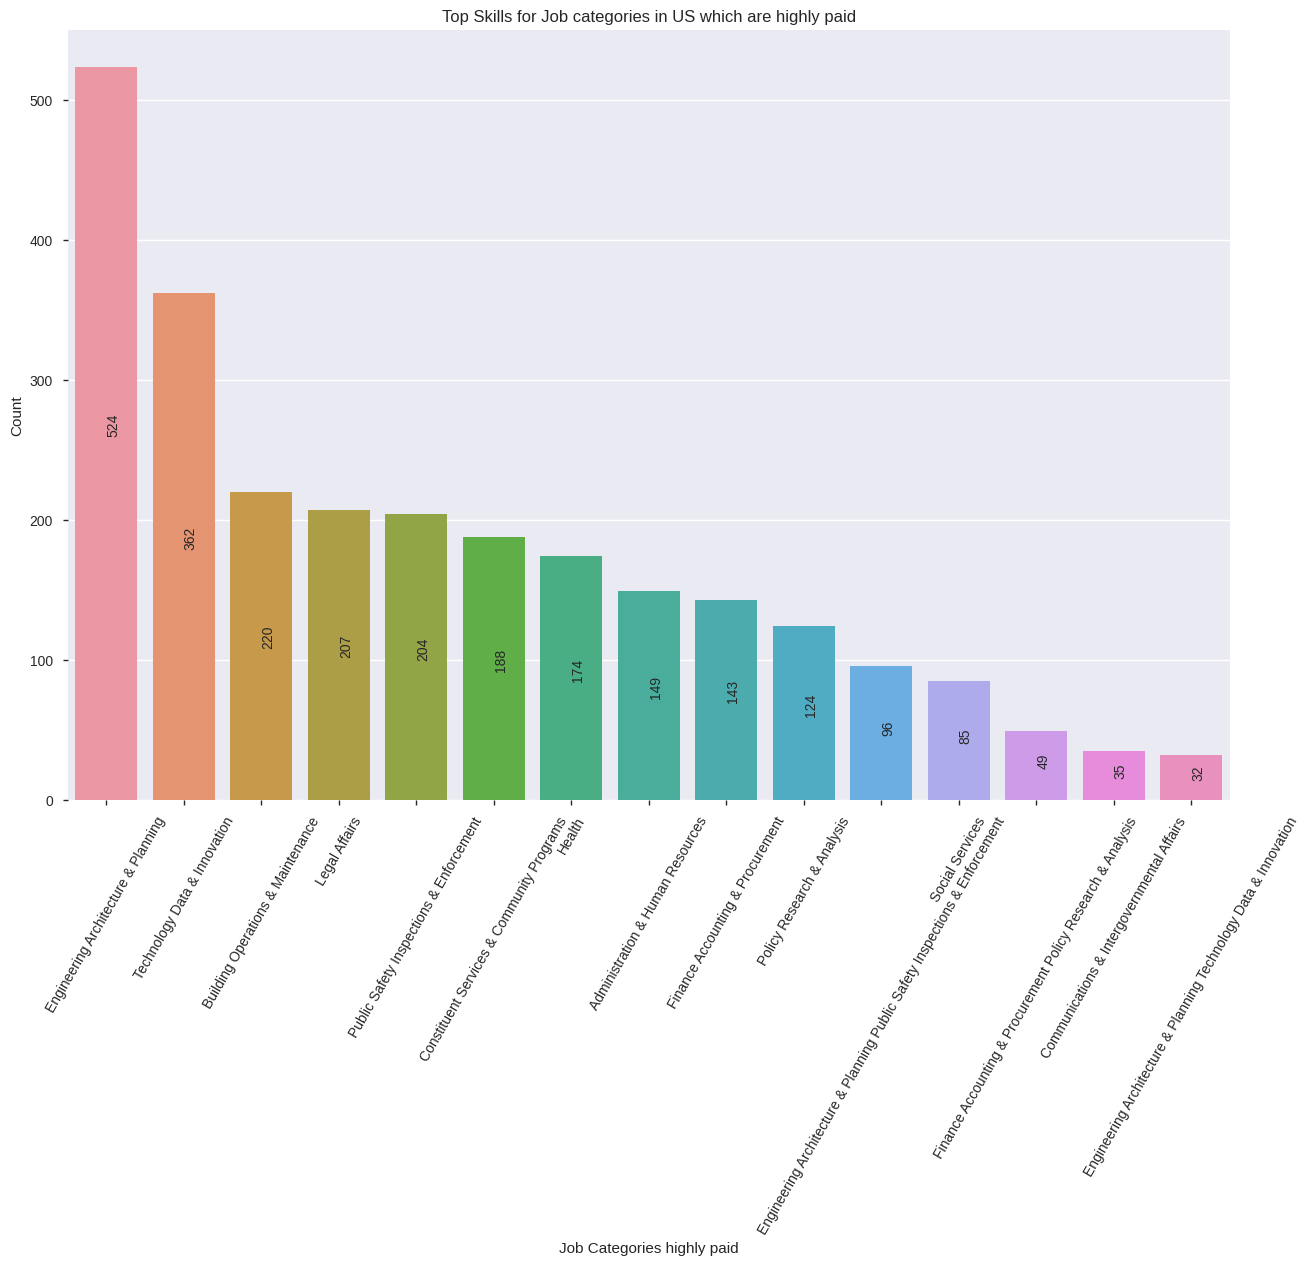

In [37]:
TopJobCategs=skillvsSalaries['jobCategory'].dropna().tolist()
JobCategList=[]
for value in TopJobCategs:
    temp=value.split(',')
    JobCategList.append("".join(temp))
values, counts = np.unique(JobCategList, return_counts=True)
TopJobCategsDF=pd.DataFrame({'jobCategories':values, 'count':counts})
TopJobCategsDF.sort_values(['count'],ascending=False, inplace = True)
TopJobCategsDF=TopJobCategsDF.reset_index(drop=True)

print("The Top 10 Job Categories")
print(TopJobCategsDF[:15])

bar_plot(TopJobCategsDF['jobCategories'][:15],TopJobCategsDF['count'][:15],'Job Categories highly paid','Count','Top Skills for Job categories in US which are highly paid',TopJobCategsDF['count'][:15])

Identifying the data for clustering method. Extracting just the attributes ('NormalizedFromSalHrly', 'NormalizedToSalHrly','YrsExpVal',"Job Category")

In [38]:
NYJobClusterData=NYJobData1[['NormalizedFromSalHrly', 'NormalizedToSalHrly','YrsExpVal','Job Category']]
NYJobClusterData.dropna(inplace = True)
NYJobClusterData.reset_index(inplace = True)
NYJobClusterData.drop(columns = ['index'],inplace = True)

Histogram plot of the Mximum salary range per hour

In [39]:
tooltip = NYJobClusterData
fig = px.histogram(tooltip, x="NormalizedToSalHrly")
fig.show()

DBSCAN Clustering method for the data post applying One Hot encoder on the Categorizal text data(Job Category)

In [40]:
NYJobClusterDataEnc = pd.get_dummies(NYJobClusterData,columns = ['Job Category'])
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(NYJobClusterDataEnc)
NYJobClusterData['DBScanLbl'] = list(db_default.labels_)
#NYJobClusterData.drop(columns = ['DBScanLbl'], inplace = True)

Woking with KMEANS Clustering to identify the best possible clusters based on SSE(Sum of Squared differences from the point to actual mean of the points in cluster) & Silhoutte coeffecient.

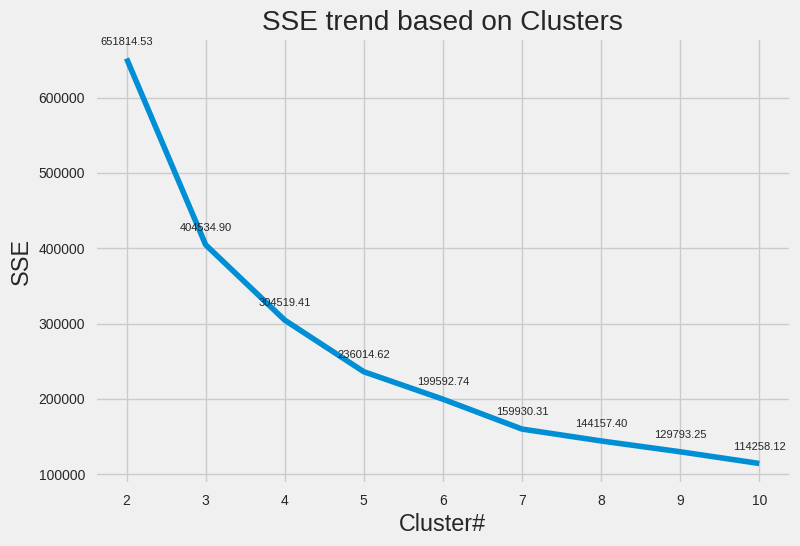

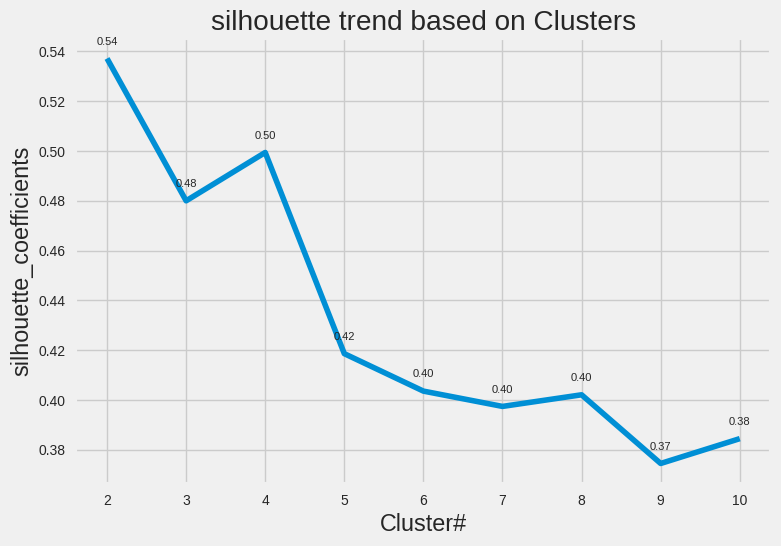

In [41]:
rangestart,rangeend = 2,11
silhouette_coefficients,sse = [], []
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}
for k in range(rangestart, rangeend):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(NYJobClusterDataEnc)
  sse.append(kmeans.inertia_)
  score = silhouette_score(NYJobClusterDataEnc, kmeans.labels_)
  silhouette_coefficients.append(score)
lineplot(rangestart,rangeend,sse,'Cluster#','SSE','SSE trend based on Clusters')
print('\n')
lineplot(rangestart,rangeend,silhouette_coefficients,'Cluster#','silhouette_coefficients','silhouette trend based on Clusters')

Moving ahead with Silhoutte Coeff. Higher the Silhoutte Coeff Higher the accuracy of the Clustering method. With Clusters = 2, KMEANS has a highest Cluctering Coeff. Going ahead with number of clusters as 2

,pcol1,pcol2,Label
0,-20.732554,1.897530,0
1,-20.732554,1.897530,0
2,-11.595662,6.776479,0
3,-11.595662,6.776479,0
4,-6.323683,-4.608758,0
...,...,...,...
2836,12.371048,-8.547893,1
2837,-7.821643,-1.305647,0
2838,-7.821643,-1.305647,0
2839,-2.062212,5.946252,0


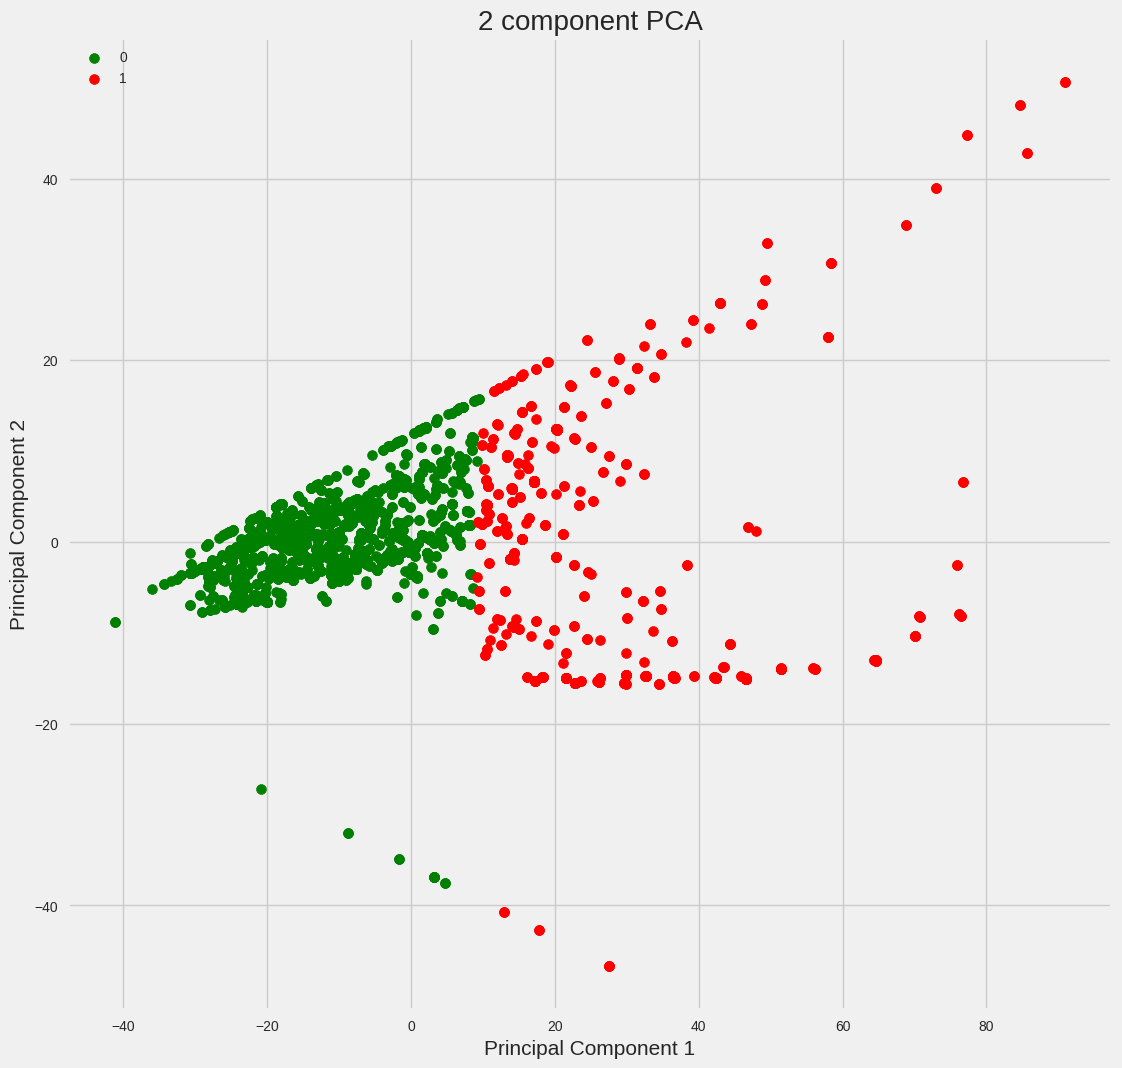

In [43]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
KMEANLbl = kmeans.fit(NYJobClusterDataEnc)
lbls = KMEANLbl.fit_predict(NYJobClusterDataEnc)
NYJobClusterDataEnc1 = NYJobClusterDataEnc
NYJobClusterDataEnc1['Label'] = lbls
NYJobClusterDataEnc1x,NYJobClusterDataEnc1y = NYJobClusterDataEnc1[:-1],NYJobClusterDataEnc1.iloc[ :, -1:]
getPCAattr(NYJobClusterDataEnc1x,NYJobClusterDataEnc1y)